## Data collection

In [1]:
import os, sys, random
from numpy import mat
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser, CifFile
import json
import csv
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

from utils.CSID_API import ICSDClient
import aflow as af

#### Data from Materials project

In [2]:
API_TOKEN = os.environ.get("MPTOKEN")
# print(API_TOKEN)

In [3]:
mpr = MPRester(API_TOKEN)

crt = {
    # 'elements': {'$all': ['N']},
    'nelements': 3,
    #'band_gap': {'$lt': 1},
    # 'anonymous_formula': {"A": 1, "B": 1, "C": 3}
}
prt = ['material_id', 'pretty_formula', 'full_formula', 'band_gap', 'unit_cell_formula', 'elements']

materials = mpr.query(criteria=crt, properties=prt)

100%|██████████| 59023/59023 [02:22<00:00, 415.54it/s]


In [4]:
CANDIDATE_IDS = []

for material in materials:
    CANDIDATE_IDS.append(material['material_id'])

print(CANDIDATE_IDS[:5])

['mp-983586', 'mp-1183079', 'mp-1183067', 'mp-1183063', 'mp-862549']


#### Data from CSID

In [7]:
client = ICSDClient("DEMOICSD62466", "RATICK")

b'Personal Authentication failed for login=DEMOICSD62466 ip=197.237.197.60(no Authorisation for API!)'
b'Logout not successful. No preceding authentication or token invalid/expired.'


#### Data from Aflow

In [25]:
result = af.search(
     ).filter(af.K.species == "N"
     ).orderby(af.K.energy_atom)
a0 = result

In [27]:
for r in result:
    if len(r.species) == 3:
        print(r.species)

print(len(result))

['N', 'Ta', 'W']
['N', 'Ta', 'W']
['N', 'Ta', 'W']
['N', 'Ta', 'W']
['Hf', 'N', 'W']
['Hf', 'N', 'Ta']
['N', 'Nb', 'W']
['Hf', 'N', 'Ta']
['N', 'Nb', 'Ta']
['N', 'Nb', 'Ta']
['Mo', 'N', 'Ta']
['Hf', 'N', 'W']
['N', 'Nb', 'W']
['N', 'Nb', 'W']
['Hf', 'N', 'W']
['Mo', 'N', 'W']
['Mo', 'N', 'W']
['N', 'Nb', 'W']
['Mo', 'N', 'Ta']
['Mo', 'N', 'W']
['Mo', 'N', 'Ta']
['Mo', 'N', 'W']
['Mo', 'N', 'Ta']
['Hf', 'N', 'W']
['N', 'V', 'W']
['Hf', 'N', 'Ta']
['N', 'Nb', 'Ta']
['N', 'W', 'Zr']
['N', 'Nb', 'Ta']
['N', 'V', 'W']
['Hf', 'N', 'Ta']
['N', 'Ta', 'Zr']
['N', 'Ti', 'W']
['N', 'Ta', 'V']
['Cr', 'N', 'W']
['Hf', 'N', 'Nb']
['Cr', 'N', 'W']
['Hf', 'Mo', 'N']
['N', 'Ta', 'Zr']
['N', 'Ta', 'V']
['Cr', 'N', 'Ta']
['Cr', 'N', 'Ta']
['N', 'Ta', 'Ti']
['Hf', 'N', 'Nb']
['N', 'V', 'W']
['N', 'Ta', 'V']
['N', 'W', 'Zr']
['Mo', 'N', 'Nb']
['Cr', 'N', 'Ta']
['N', 'W', 'Zr']
['Cr', 'N', 'W']
['N', 'Ta', 'Ti']
['N', 'V', 'W']
['Hf', 'Mo', 'N']
['N', 'Ta', 'Zr']
['N', 'Ti', 'W']
['Hf', 'Mo', 'N']
['Mo', 'N

## Data processing

In [5]:
## Get the cif data


mpr = MPRester(API_TOKEN)

crt = {
    'material_id': {'$in': CANDIDATE_IDS},
}
prt = ['material_id', 'pretty_formula', 'icsd_ids', 'cif', 'elasticity']

cif_candidates = mpr.query(criteria=crt, properties=prt)

MPRestError: REST query returned with error status code 413. Content: b'<html>\r\n<head><title>413 Request Entity Too Large</title></head>\r\n<body>\r\n<center><h1>413 Request Entity Too Large</h1></center>\r\n<hr><center>nginx</center>\r\n</body>\r\n</html>\r\n'

In [11]:
for mat in cif_candidates[:5]:
    if mat['elasticity'] is None:
        print(mat['material_id'], mat['pretty_formula'])

mp-1001015 Y2ZnS4


In [12]:
## Find all the materials with elastic properties


ID_PROPS_DATA = []
count = 1
for i in cif_candidates:
    if i['elasticity'] is not None:
        # print(f"processing {i['pretty_formula']}")
        
        ## Create CIF files from
        mat_name = f"{i['pretty_formula']}_{i['material_id']}"
        bulk_modulus = i['elasticity']['K_VRH']

        with open(f"cgcnn-mod-transformers/data/transformers-reg/{mat_name}.cif", 'w') as ff: 
            ff.write(i['cif'])
        
        ## Create csv data
        ID_PROPS_DATA.append([mat_name, bulk_modulus])
        
        # break
        count+=1

        # if count >= 20: break

with open("cgcnn-mod-transformers/data/transformers-reg/id_prop.csv", 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)


print(count)

5659


## Training

In [20]:
ROOT_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])

main_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/main.py")
data_file = os.path.join(ROOT_DIR, "src/cgcnn-mod-transformers/data/transformers-reg")
python_exe = os.path.join(ROOT_DIR, "venv/Scripts/python.exe")

EPOCHS = 30
run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{main_file}\" {run_options} \"{data_file}\""
print(cmd)

result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
print(result.stdout.decode("utf-8"))


python "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/main.py" --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs 150 "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\src/cgcnn-mod-transformers/data/transformers-reg"
Epoch: [0][0/14]	Time 8.049 (8.049)	Data 5.719 (5.719)	Loss 1.2736 (1.2736)	MAE 52.847 (52.847)
Epoch: [0][10/14]	Time 6.463 (6.689)	Data 5.712 (5.736)	Loss 1.0364 (0.7592)	MAE 41.370 (40.042)
Test: [0/5]	Time 5.789 (5.789)	Loss 1.1315 (1.1315)	MAE 49.213 (49.213)
 * MAE 48.896
Epoch: [1][0/14]	Time 0.863 (0.863)	Data 0.017 (0.017)	Loss 0.2862 (0.2862)	MAE 24.567 (24.567)
Epoch: [1][10/14]	Time 0.813 (0.872)	Data 0.015 (0.014)	Loss 0.1983 (0.3750)	MAE 18.898 (24.956)
Test: [0/5]	Time 0.203 (0.203)	Loss 0.8996 (0.8996)	MAE 40.490 (40.490)
 * MAE 41.276
Epoch: [2][0/14]	Time 0.812 (0.812)	Data 0.017 (0.017)	Loss 0.1640 (0.1640)	MAE 16.888 (16.888)
Epoch: [2][10/14]	Time 0.864 (0.860)	Data

In [26]:
result_file = os.path.join(ROOT_DIR, "src/test_results.csv")

df = pd.read_csv(result_file)
df.dropna(subset=['material'], inplace=True)
df.head()
# df.plot(x="material", y=["test", "result"], kind='bar', figsize=(22, 12),
#         title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [Epochs={EPOCHS}, TOTAL-DATASET={count}, Train-Validation-Test_Ratios=6:2:2]",
#         sort_columns=True)


,material,test,result
0,ScBRh3_mp-569875,194.0,187.075714
2,Tm2MgIr_mp-865360,94.0,90.655945
4,AgSbTe2_mp-12360,50.0,40.158279
6,UGa5Ni_mp-21251,91.0,91.519989
8,TiFe2Si_mp-866141,229.0,249.340485


<AxesSubplot:xlabel='test', ylabel='result'>

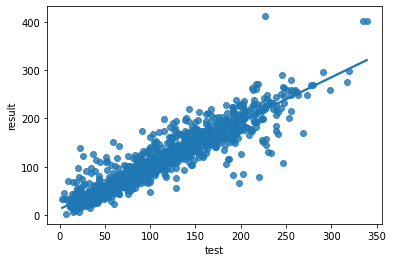

In [25]:
sb.regplot(x = "test",
        y = "result",
        ci = None,
        data = df)